In [8]:
import pandas as pd
import numpy as np

from scipy import stats as sc_stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

2023-05-01 22:18:31.323551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import sys
from os.path import dirname
sys.path.append(dirname("../"))

In [4]:
from src.edl import dense_layers,dense_loss

In [5]:
%load_ext autoreload
%autoreload 2

### Benchmark Model for normal simulated data

### Gen synthetic Weibull data

(2000, 1)
(2000, 1)


Text(0.5, 1.0, 'Distribution of y')

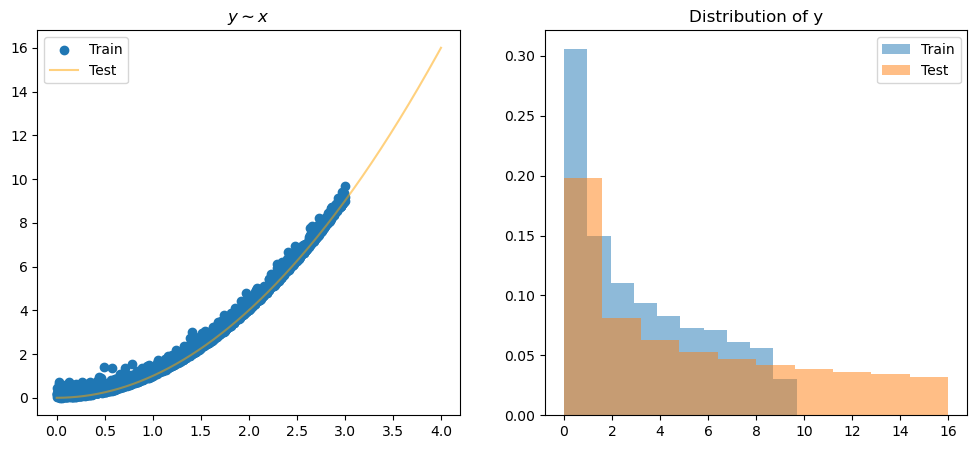

In [6]:
def my_data_weibulll(x_min, x_max, n, train=True):
    x = np.linspace(x_min, x_max, n)
    x = np.expand_dims(x, -1).astype(np.float32)
    print (x.shape)
    if train:
        y = x**2 + 0.2*np.random.weibull(a=1.2,size=x.shape)
    else:
        y = x**2
    return x, y

x_train, y_train = my_data_weibulll(0.0, 3, 2000)
x_test, y_test = my_data_weibulll(0.0,4, 2000, train=False)

fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].scatter(x_train,y_train,label="Train")
ax[0].plot(x_test,y_test,label="Test",alpha = 0.5, color="orange")
ax[0].legend()
ax[0].set_title("$y \sim x$")
ax[1].hist(y_train,density=True,alpha=0.5,label="Train")
ax[1].hist(y_test,density=True,alpha=0.5,label="Test")
ax[1].legend()
ax[1].set_title("Distribution of y")

In [47]:
def results_normal_model(c):
    edl_model2 = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_dim=x_train.shape[1]),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        dense_layers.DenseNormalGamma(1),
    ])
    
    def EvidentialRegressionLoss(true, pred):
        return dense_loss.EvidentialRegression(true, pred, coeff=c)
    
    # Compile and fit the model!
    edl_model2.compile(
        optimizer=tf.keras.optimizers.Adam(5e-4),
        loss=EvidentialRegressionLoss)

    edl_model2.fit(x_train, y_train, batch_size=100, epochs=340, verbose = 0)
    y_pred = edl_model2(x_test).numpy()
    return y_pred,edl_model2

In [48]:
results_normal = {}
for c_i in [1e-2,1e-3,1e-4]:
    results_normal[c_i] = results_normal_model(c_i)
    print (f"For c={c_i}, MSE = {mean_squared_error(y_test,results_normal[c_i][0][:,0])}")

For c=0.01, MSE = 0.1783973127603531
For c=0.001, MSE = 0.16080491244792938
For c=0.0001, MSE = 0.1475342959165573


In [51]:
edl_model2 = results_normal[0.0001][1]
edl_model2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 1)                 2         
                                                                 
 dense_53 (Dense)            (None, 64)                128       
                                                                 
 dense_54 (Dense)            (None, 64)                4160      
                                                                 
 dense_normal_gamma_13 (Dens  (None, 4)                260       
 eNormalGamma)                                                   
                                                                 
Total params: 4,550
Trainable params: 4,550
Non-trainable params: 0
_________________________________________________________________


In [209]:
y_pred = edl_model2(x_train).numpy()
mean_squared_error(y_train,y_pred[:,0])

0.02415999623002387

Text(0.5, 1.0, '$y \\sim x$ for Benchmark evidence regression')

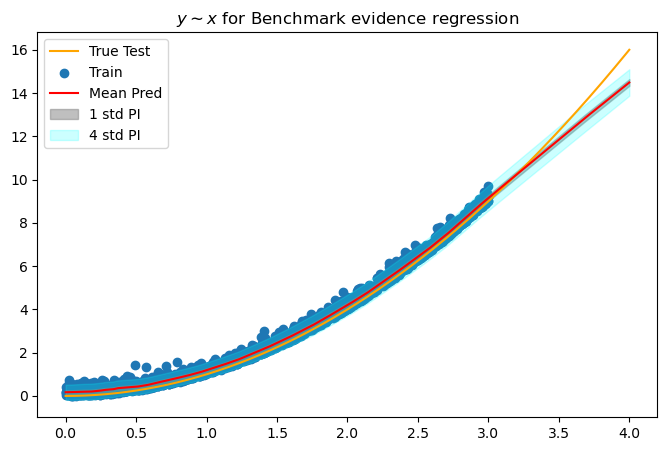

In [49]:
y_pred = edl_model2(x_test).numpy()
mu, v, alpha, beta = y_pred[:,0],y_pred[:,1],y_pred[:,2],y_pred[:,3]
var = np.sqrt(beta / (v * (alpha - 1)))
              
#plot
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(x_test,y_test,label="True Test",alpha = 1, color="orange")
ax.scatter(x_train,y_train,label="Train")
ax.plot(x_test.reshape(2000), mu, zorder=3, label="Mean Pred",color="red")
plt.fill_between(x=x_test.reshape(2000),\
                 y1=(mu - 1 * var).reshape(2000), \
                 y2=(mu + 1 * var).reshape(2000),\
                 label="1 std PI",color="grey",alpha=0.5)
plt.fill_between(x=x_test.reshape(2000),\
                 y1=(mu - 4 * var).reshape(2000), \
                 y2=(mu + 4 * var).reshape(2000),\
                 label="4 std PI",color="cyan",alpha=0.2)
# ax.set_ylim(-10,40)
ax.legend()
ax.set_title("$y \sim x$ for Benchmark evidence regression")

In [53]:
var.mean()

0.11873814

In [54]:
print ("var for test data")
var.reshape(x_test.shape)[x_test>3.0].mean()

var for test data


0.15180612

Text(0.5, 1.0, 'Distribnution of y-pred')

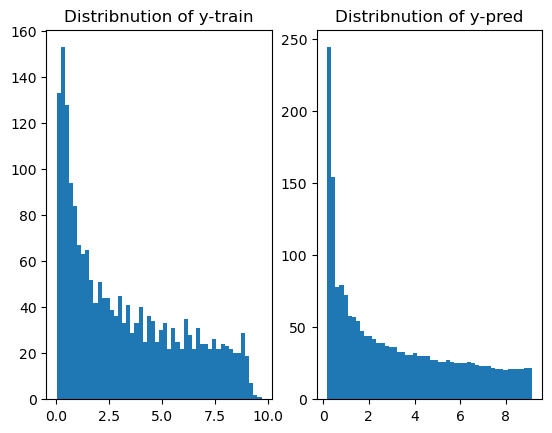

In [56]:
plt.subplot(121)
plt.hist(y_train,bins=50)
plt.title("Distribnution of y-train")
plt.subplot(122)
plt.hist(edl_model2(x_train).numpy()[:,0],bins=50)
plt.title("Distribnution of y-pred")

### same weibull data, weibull evidence

(1.0393059393686146, 0.0, 3.2348817433166603)


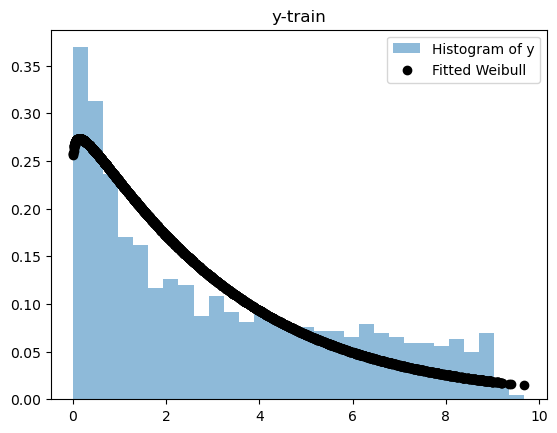

In [57]:
rv = sc_stats.weibull_min.fit(y_train, floc=0.0)
print (rv)
plt.hist(y_train,alpha=0.5,density=True,bins=30,label="Histogram of y")
plt.scatter(y_train, sc_stats.weibull_min.pdf(y_train,*rv),label="Fitted Weibull",color="black")
plt.title("y-train")
plt.legend()

In [58]:
from src.weibull_edl import loss_and_layers

In [59]:
from scipy.special import loggamma

In [98]:
def results_weibull_model(c):
    k=1.04
    weibull_model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_dim=x_train.shape[1]),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="leaky_relu"),
        tf.keras.layers.Dense(100, activation="leaky_relu"),
        tf.keras.layers.Dense(77, activation="leaky_relu"),
        loss_and_layers.DenseWeibullGamma(1),
    ])

    def weibullLoss(true, pred):
        return loss_and_layers.weibull_evidence_Regression(true, pred, k=k, coeff=c)

    # Compile and fit the model!
    weibull_model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-4),
        loss=weibullLoss)
    weibull_model.fit(x_train, y_train, batch_size=100, epochs=610, verbose = 0)
    y_pred = weibull_model.predict(x_test);
    alpha,beta = y_pred[:,0],y_pred[:,1]
    return y_pred,weibull_model

In [99]:
results_wibull = {}
k=1.04
for c_i in np.logspace(-3,1,20):
    results_wibull[c_i] = results_weibull_model(c_i)
    y_pred = results_wibull[c_i][0]
    alpha,beta = y_pred[:,0],y_pred[:,1]
    mean_pred_log = (loggamma(1+ (1/k)) - loggamma(alpha) + loggamma(alpha-(1/k))\
                + (1/k)*np.log(beta))
    mu = np.exp(mean_pred_log)
    print (f"For c={c_i}, MSE = {mean_squared_error(y_test,mu)}")

63/63 [==============================] - 0s 1ms/step
For c=0.001, MSE = 2.4937314987182617
63/63 [==============================] - 0s 976us/step
For c=0.001623776739188721, MSE = 1.4002158641815186
63/63 [==============================] - 0s 1ms/step
For c=0.0026366508987303583, MSE = 2.9424757957458496
63/63 [==============================] - 0s 1ms/step
For c=0.004281332398719396, MSE = 1.6623955965042114
63/63 [==============================] - 0s 1ms/step
For c=0.0069519279617756054, MSE = 2.0075700283050537
63/63 [==============================] - 0s 1ms/step
For c=0.011288378916846888, MSE = 1.7482588291168213
63/63 [==============================] - 0s 1ms/step
For c=0.018329807108324356, MSE = 1.3986538648605347
63/63 [==============================] - 0s 1ms/step
For c=0.029763514416313176, MSE = 0.7111510038375854
63/63 [==============================] - 0s 1ms/step
For c=0.04832930238571752, MSE = 1.0196640491485596
63/63 [==============================] - 0s 1ms/step
For c

### Results for best model

In [172]:
weibull_model = results_wibull[0.5455594781168515][1]

In [208]:
weibull_model.summary()

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_476 (Dense)           (None, 1)                 2         
                                                                 
 dense_477 (Dense)           (None, 256)               512       
                                                                 
 dense_478 (Dense)           (None, 128)               32896     
                                                                 
 dense_479 (Dense)           (None, 100)               12900     
                                                                 
 dense_480 (Dense)           (None, 77)                7777      
                                                                 
 dense_weibull_gamma_77 (Den  (None, 2)                156       
 seWeibullGamma)                                                 
                                                     

In [206]:
y_pred = weibull_model.predict(x_train)
alpha,beta = y_pred[:,0],y_pred[:,1]

mean_pred_log = (loggamma(1+ (1/k)) - loggamma(alpha) + loggamma(alpha-(1/k))\
                + (1/k)*np.log(beta))
mu = np.exp(mean_pred_log)
mean_squared_error(y_train,mu)

63/63 [==============================] - 0s 1ms/step


0.025673786260440735

In [207]:
y_pred = weibull_model.predict(x_test)
alpha,beta = y_pred[:,0],y_pred[:,1]

mean_pred_log = (loggamma(1+ (1/k)) - loggamma(alpha) + loggamma(alpha-(1/k))\
                + (1/k)*np.log(beta))
mu = np.exp(mean_pred_log)

var_term1 = (loggamma(1+ (2/k)) - loggamma(alpha) + loggamma(alpha-(2/k))\
                + (2/k)*np.log(beta))
var = np.exp(var_term1) - np.square(mu)

63/63 [==============================] - 0s 1ms/step


In [198]:
np.sqrt(var).reshape(x_test.shape)[x_test>3.0].mean()

18.314327

In [200]:
np.sqrt(var).mean()

8.392265

### Sol'n using analytical

Text(0.5, 1.0, '$y \\sim x$, Prediction using analytical soln')

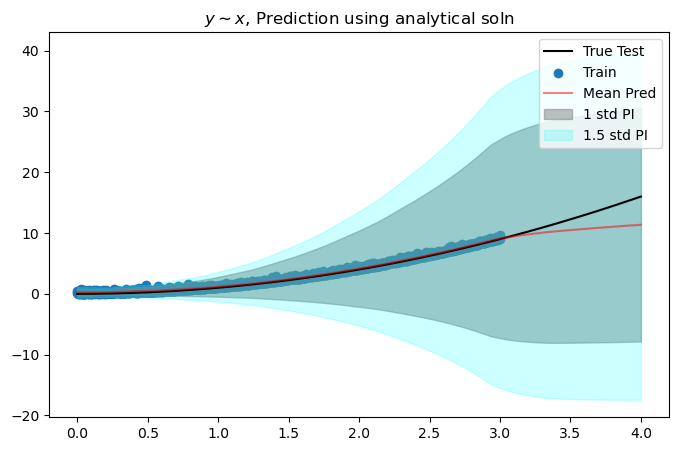

In [174]:
#plot
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(x_test,y_test,label="True Test",alpha = 1.0,color="black")
ax.scatter(x_train,y_train,label="Train")
ax.plot(x_test.reshape(2000), mu, zorder=3, label="Mean Pred",color="red", alpha = 0.5)
# var = np.std(y_pred_check)
plt.fill_between(x=x_test.reshape(2000),\
                 y1=(mu - 1 * np.sqrt(var)).reshape(2000), \
                 y2=(mu + 1 * np.sqrt(var)).reshape(2000),\
                 label="1 std PI",color="grey",alpha=0.5)
plt.fill_between(x=x_test.reshape(2000),\
                 y1=(mu - 1.5 * np.sqrt(var)).reshape(2000), \
                 y2=(mu + 1.5 * np.sqrt(var)).reshape(2000),\
                 label="1.5 std PI",color="cyan",alpha=0.2)
# ax.set_ylim(-100,400)
# ax.set_xlim(0,5)
ax.legend()
ax.set_title("$y \sim x$, Prediction using analytical soln")

### Sol'n using sampling

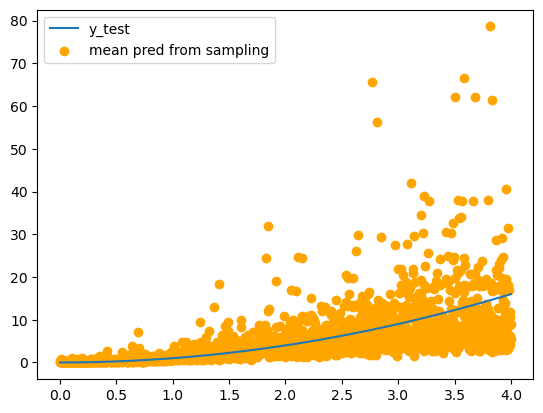

In [175]:
from scipy.stats import invgamma
rv = invgamma(a=alpha,scale=beta*1.0)
theta = rv.rvs(2000)
lambda_weibull = theta**(1/k)
y_pred_check = np.array([lambda_weibull*np.random.weibull(a=k) for i in range(100)]).mean(axis=0)

plt.plot(x_test,y_test,label="y_test")
plt.scatter(x_test,y_pred_check,color="orange",label="mean pred from sampling")
plt.legend()

Text(0.5, 1.0, '$y \\sim x$, Prediction using sampling')

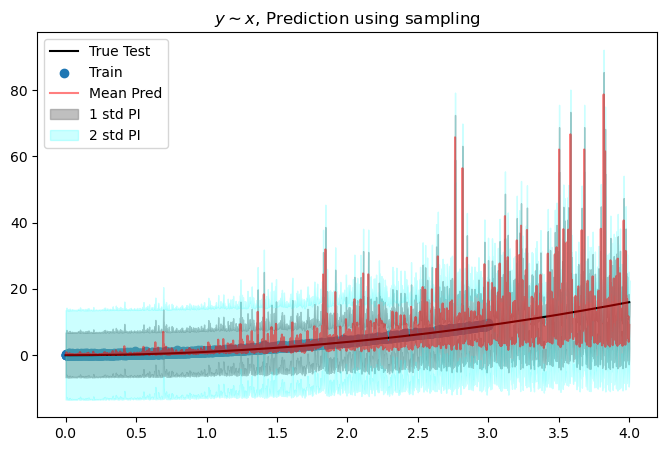

In [176]:
#plot
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(x_test,y_test,label="True Test",alpha = 1.0,color="black")
ax.scatter(x_train,y_train,label="Train")
ax.plot(x_test.reshape(2000), y_pred_check, zorder=3, label="Mean Pred",color="red", alpha = 0.5)
var = np.std(y_pred_check)
plt.fill_between(x=x_test.reshape(2000),\
                 y1=(y_pred_check - 1 * var).reshape(2000), \
                 y2=(y_pred_check + 1 * var).reshape(2000),\
                 label="1 std PI",color="grey",alpha=0.5)
plt.fill_between(x=x_test.reshape(2000),\
                 y1=(y_pred_check - 2 * var).reshape(2000), \
                 y2=(y_pred_check + 2 * var).reshape(2000),\
                 label="2 std PI",color="cyan",alpha=0.2)
# ax.set_ylim(-100,400)
# ax.set_xlim(0,5)
ax.legend()
ax.set_title("$y \sim x$, Prediction using sampling")

/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_11460/1779324458.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)


Text(0.5, 1.0, 'Distribnution of y-pred (Weibull)')

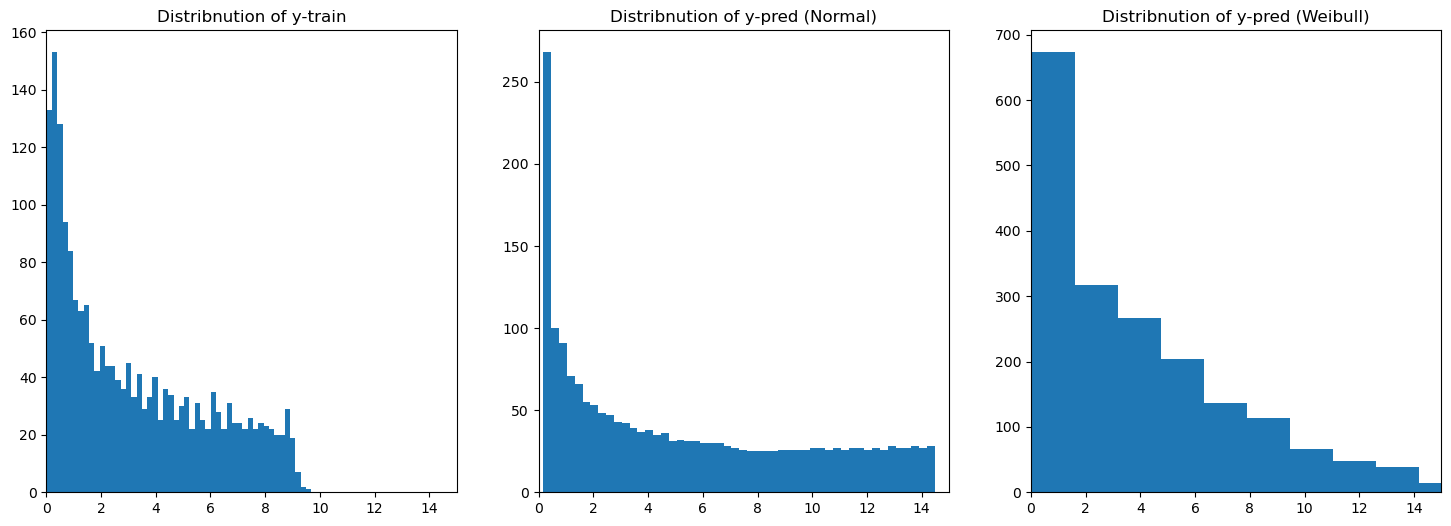

In [202]:
fig,ax=plt.subplots(figsize=(18,6))
plt.subplot(131)
plt.hist(y_train,bins=50)
plt.title("Distribnution of y-train")
plt.xlim(0,15)
plt.subplot(132)
plt.hist(edl_model2(x_test).numpy()[:,0],bins=50)
plt.xlim(0,15)
plt.title("Distribnution of y-pred (Normal)")
plt.subplot(133)
plt.hist(y_pred_check,bins=50)
plt.xlim(0,15)
plt.title("Distribnution of y-pred (Weibull)")

### comparision with analytical and sampling

In [203]:
np.corrcoef(mu,y_pred_check)

array([[1.        , 0.59295956],
       [0.59295956, 1.        ]])

/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_11460/926592861.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


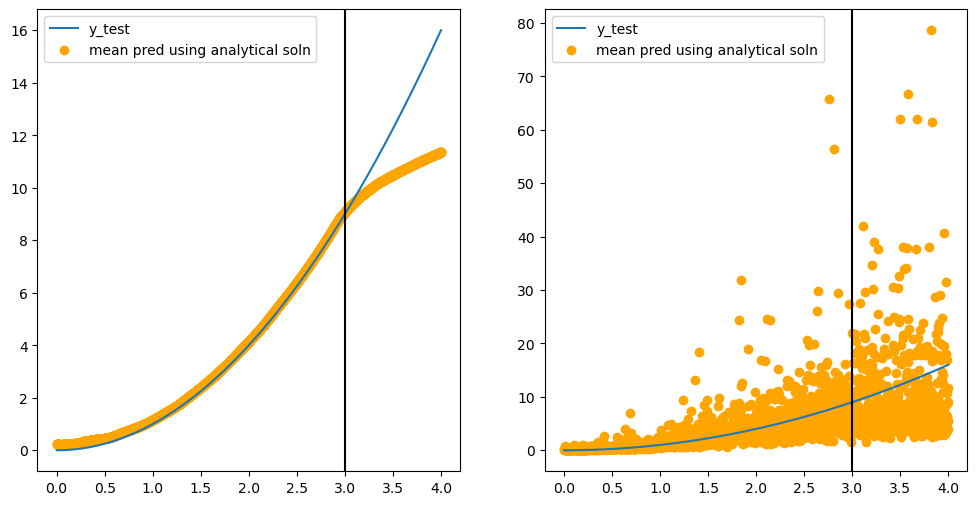

In [204]:
fig,ax = plt.subplots(figsize=(12,6))
plt.subplot(121)
plt.plot(x_test,y_test,label="y_test")
plt.scatter(x_test,mu,color="orange",label="mean pred using analytical soln")
plt.axvline(3.0,color="black")
plt.legend()
plt.subplot(122)
plt.plot(x_test,y_test,label="y_test")
plt.scatter(x_test,y_pred_check,color="orange",label="mean pred using analytical soln")
plt.axvline(3.0,color="black")
plt.legend()

k=1.10
weibull_model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_dim=x_train.shape[1]),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="softmax"),
        tf.keras.layers.Dense(32, activation="relu"),
        loss_and_layers.DenseWeibullGamma(1),
    ])

def weibullLoss(true, pred):
        return loss_and_layers.weibull_evidence_Regression(true, pred, k=k, coeff=1e-3)

# Compile and fit the model!
weibull_model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=weibullLoss)
    

weibull_model.fit(x_train, y_train, batch_size=250, epochs=610)

y_pred = weibull_model.predict(x_test)
alpha,beta = y_pred[:,0],y_pred[:,1]

from scipy.stats import invgamma
rv = invgamma(a=alpha,scale=beta*1.0)
theta = rv.rvs(2000)
lambda_weibull = theta**(1/k)
y_pred_check = np.array([lambda_weibull*np.random.weibull(a=k) for i in range(100)]).mean(axis=0)

plt.plot(x_test,y_test,label="y_test")
plt.scatter(x_test,y_pred_check,color="orange",label="mean pred from sampling")
plt.legend()

#plot
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(x_test,y_test,label="True Test",alpha = 1.0,color="black")
ax.scatter(x_train,y_train,label="Train")
ax.plot(x_test.reshape(2000), y_pred_check, zorder=3, label="Mean Pred",color="red", alpha = 0.5)
var = np.std(y_pred_check)
plt.fill_between(x=x_test.reshape(2000),\
                 y1=(y_pred_check - 1 * var).reshape(2000), \
                 y2=(y_pred_check + 1 * var).reshape(2000),\
                 label="1 std PI",color="grey",alpha=0.5)
plt.fill_between(x=x_test.reshape(2000),\
                 y1=(y_pred_check - 2 * var).reshape(2000), \
                 y2=(y_pred_check + 2 * var).reshape(2000),\
                 label="2 std PI",color="cyan",alpha=0.2)
# ax.set_ylim(-100,400)
# ax.set_xlim(0,5)
ax.legend()
ax.set_title("$y \sim x$, Prediction using sampling")

fig,ax=plt.subplots(figsize=(18,6))
plt.subplot(131)
plt.hist(y_train,bins=50)
plt.title("Distribnution of y-train")
plt.subplot(132)
plt.hist(edl_model2(x_test).numpy()[:,0],bins=50)
plt.title("Distribnution of y-pred (Normal)")
plt.subplot(133)
plt.hist(y_pred_check,bins=50)
plt.title("Distribnution of y-pred (Weibull)")

from scipy.special import loggamma

mean_pred_log = (loggamma(1+ (1/k)) - loggamma(alpha) + loggamma(alpha-(1/k))\
                + (1/k)*np.log(beta))
mu = np.exp(mean_pred_log)

var_term1 = (loggamma(1+ (2/k)) - loggamma(alpha) + loggamma(alpha-(2/k))\
                + (2/k)*np.log(beta))
var = np.exp(var_term1) - np.square(mu)
var

plt.plot(x_test,y_test,label="y_test")
plt.scatter(x_test,mu,color="orange",label="mean pred using analytical soln")
plt.legend()

#plot
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(x_test,y_test,label="True Test",alpha = 1.0,color="black")
ax.scatter(x_train,y_train,label="Train")
ax.plot(x_test.reshape(2000), mu, zorder=3, label="Mean Pred",color="red", alpha = 0.5)
# var = np.std(y_pred_check)
plt.fill_between(x=x_test.reshape(2000),\
                 y1=(mu - 1 * np.sqrt(var)).reshape(2000), \
                 y2=(mu + 1 * np.sqrt(var)).reshape(2000),\
                 label="1 std PI",color="grey",alpha=0.5)
plt.fill_between(x=x_test.reshape(2000),\
                 y1=(mu - 1.5 * np.sqrt(var)).reshape(2000), \
                 y2=(mu + 1.5 * np.sqrt(var)).reshape(2000),\
                 label="2 std PI",color="cyan",alpha=0.2)
# ax.set_ylim(-100,400)
# ax.set_xlim(0,5)
ax.legend()
ax.set_title("$y \sim x$, Prediction using analytical soln")